# Generating LHC data with Flows

This week we will use Invertible Neural Networks (INNs) to generate LHC data.  They are a type of normalising flow.  The task this week will be exactly as it was with the GAN, except using the INN.  Instead of doing part of the work for you, I have instead provided some example code for how to define an INN, how to write down it's loss function, and how to sample from it.

Background:
- Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful
- As a proof of concept, we will show how a normalising flow, specifically an Invertible Neural Network (INN), can be optimised to generate events simulated by traditional high energy physics simulation software
- The process we are studying is Drell-Yan: $pp\rightarrow Z\rightarrow \mu\mu$
- Naively, the dimension of this phase space is 8D, the 4 momentum of the two final state particles
- The generative network samples random noise from a unit Normal distribution, passes it through an invertible network to produce an 8D output
- **There are detailed notes on this in your lecture notes, please read them!**

Interesting papers:
- Invertible Networks or Partons to Detector and Back Again
    - Bellagente et al
    - https://arxiv.org/abs/2006.06685
- Generative Networks for Precision Enthusiasts
    - Butter et al
    - https://arxiv.org/abs/2110.13632

Outline:
- Imports and plotting set-up
- Study the data
- Datasets and dataloaders
- Building and optimising the INN
- Study the results - let's generate some events!
- Removing redundant degrees of freedom
- Optimising the INN on the reduced data
- Study the new results
- Concluding remarks

You need install the FrEIA package to use the INN modules, you can install it from the terminal with:

The documentation can be found here:

https://github.com/VLL-HD/FrEIA

Example code for how to define an INN, how to write it's loss function, and how to sample from it:

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

## Loading the data

We can load the data from here:

In [2]:
dy_trn_data = np.load('tutorial-11-data/dy_trn_data.npy')
dy_val_data = np.load('tutorial-11-data/dy_val_data.npy')
dy_tst_data = np.load('tutorial-11-data/dy_tst_data.npy')

In [3]:
dy_trn_data.shape, dy_val_data.shape, dy_tst_data.shape

((1384081, 8), (296588, 8), (296588, 8))

Each element of the data has 8 entries, corresponding to the 4-momenta of each muon in the process.

Each entry has the form $[E_1, p_{x,1}, p_{y,1}, p_{z,1}, E_2, p_{x,2}, p_{y,2}, p_{z,2}]$.

## Study the data

We need to be able to calculate the invariant mass of each event, and the $p_T$ of the event and the jets.

Let's write a function for this:

In [4]:
def get_obs(event):
    jet1_4m = event[:,0:4]
    jet2_4m = event[:,4:]
    evnt_4m = np.sum((jet1_4m,jet2_4m), axis=0)
    
    evnt_im = np.sqrt(np.sum((evnt_4m[:,0]**2, -evnt_4m[:,1]**2, -evnt_4m[:,2]**2, -evnt_4m[:,3]**2 ), axis=0))
    
    evnt_pt = np.sqrt(evnt_4m[:,1]**2 + evnt_4m[:,2]**2)
    jet1_pt = np.sqrt(jet1_4m[:,1]**2 + jet1_4m[:,2]**2)
    jet2_pt = np.sqrt(jet2_4m[:,1]**2 + jet2_4m[:,2]**2)
    
    return evnt_im, evnt_pt, jet1_pt, jet2_pt

Now test it:

In [5]:
get_obs(dy_trn_data[0:2])

(array([90.98955316, 91.3711254 ]),
 array([0., 0.]),
 array([44.32344982, 35.10745113]),
 array([44.32344982, 35.10745113]))

The $p_T$ of the events will always be zero here due to the fact that the initial incoming protons have no transverse momentum.

Let's get the observables for the whole dataset:

In [6]:
trn_evnt_ims, trn_evnt_pts, trn_jet1_pts, trn_jet2_pts = get_obs(dy_trn_data)
val_evnt_ims, val_evnt_pts, val_jet1_pts, val_jet2_pts = get_obs(dy_val_data)
tst_evnt_ims, tst_evnt_pts, tst_jet1_pts, tst_jet2_pts = get_obs(dy_tst_data)

In [7]:
trn_evnt_ims.shape

(1384081,)

Let's plot the invariant mass of the events:

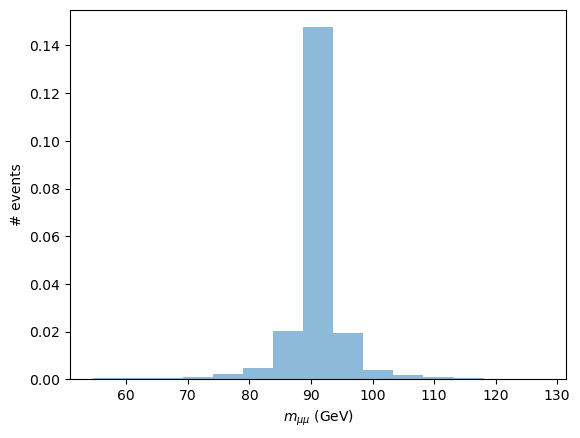

In [8]:
fig, axs = plt.subplots()

axs.hist(trn_evnt_ims, alpha=0.5, density=True, bins=15)

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("# events")
plt.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV.

Now let's look at $p_T$ distributions:

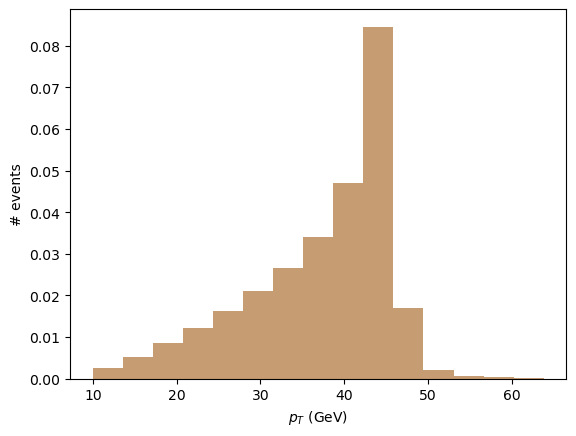

In [9]:
fig, axs = plt.subplots()

axs.hist(trn_jet1_pts, alpha=0.5, density=True, bins=15)
axs.hist(trn_jet2_pts, alpha=0.5, density=True, bins=15)

axs.set_xlabel("$p_{T}$ (GeV)")
axs.set_ylabel("# events")
plt.show()

These distributions are completely overlapping with a peak near $m_{\mu\mu}/2$.

# Datasets and dataloaders

Let's normalise the data a little bit by dividing all dimensionful quantities by $100$ GeV.

In [10]:
trn_mean = np.mean(dy_trn_data, axis=0)
trn_std = np.std(dy_trn_data, axis=0)
dy_trn_data_p = torch.Tensor((dy_trn_data - trn_mean) / trn_std)
dy_val_data_p = torch.Tensor((dy_val_data - trn_mean) / trn_std)
dy_tst_data_p = torch.Tensor((dy_tst_data - trn_mean) / trn_std)

In [11]:
trn_dataset = TensorDataset(dy_trn_data_p)
val_dataset = TensorDataset(dy_val_data_p)
tst_dataset = TensorDataset(dy_tst_data_p)

Using a bigger batch size this time, this helps for generative networks.

In [12]:
trn_dataloader = DataLoader(trn_dataset, batch_size=2500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2500, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=2500, shuffle=True)

## Building and optimising the INN

First, we set the device.

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [14]:
def inn_loss(z, ndim, log_jac_det):
    l = 0.5*torch.sum(z**2, 1) - log_jac_det
    return l.mean() / ndim

In [15]:
def train_epoch(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (x, ) in enumerate(dataloader):
        # pass data through network
        z, log_jac_det = model(x)
        
        # compute loss
        loss = inn_loss(z, ndim, log_jac_det)

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def val_pass(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x in dataloader:
            z, log_jac_det = model(x)
            vl += inn_loss(z, ndim, log_jac_det).item()

    vl /= num_batches
    print(f"avg val loss per batch: {vl:>8f}")
    
    return vl

def trn_pass(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for x in dataloader:
            z, log_jac_det = model(x)
            tl += inn_loss(z, ndim, log_jac_det).item()

    tl /= num_batches
    print(f"avg trn loss per batch: {tl:>8f}")
    
    return tl

In [17]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 10

# initialise the model and the optimizer
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 32), 
        nn.ReLU(),
        nn.Linear(32, 32), 
        nn.ReLU(),
        nn.Linear(32,  dims_out)
    )
ndim = 8
inn = Ff.SequenceINN(ndim)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)
learning_rate = 0.001
optimizer = torch.optim.Adam(inn.parameters(), lr=learning_rate)
separator()
print("model architecture")
separator()
print(inn)

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print(f"Epoch {t+1}")
    separator()
    train_epoch(trn_dataloader, inn, optimizer)
    separator()
    trn_loss = trn_pass(trn_dataloader, inn)
    trn_losses.append(trn_loss)
    separator()
    val_loss = val_pass(val_dataloader, inn)
    val_losses.append(val_loss)
    separator()
    print("|")
    
print("Done!")

-----------------------------------------------
model architecture
-----------------------------------------------
SequenceINN(
  (module_list): ModuleList(
    (0-7): 8 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=4, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=8, bias=True)
      )
    )
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.513956  [    0/1384081]
current batch loss: -0.224683  [250000/1384081]
current batch loss: -0.797416  [500000/1384081]
current batch loss: -1.013889  [750000/1384081]
current batch loss: -1.092277  [1000000/1384081]
current batch loss: -1.179089  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -1.208039
----------

## Study the results

First let's plot the training and validation losses to see how they look.

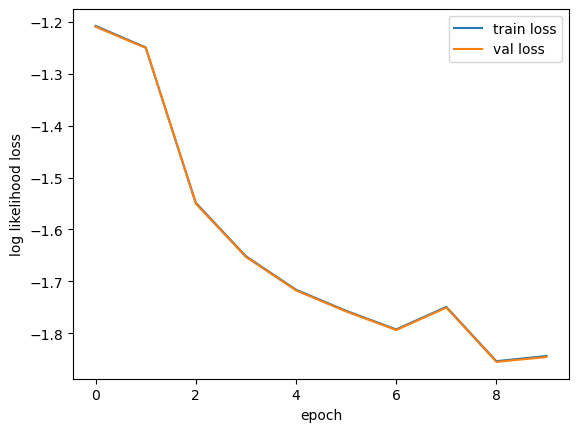

In [18]:
fig, axs = plt.subplots()

axs.plot(trn_losses, label="train loss")
axs.plot(val_losses, label="val loss")

axs.set_xlabel("epoch")
axs.set_ylabel("log likelihood loss")
axs.legend()
plt.show()

## Let's generate some events!

We first need to generate random data from the unit normal distribution, the same used during training, with the correct shape.  Here we use $10$k samples.

In [19]:
z_gen = torch.randn((10000, ndim))
x_gen, _ = inn(z_gen, rev=True)
x_gen = x_gen.detach().numpy() * trn_std + trn_mean

In [20]:
x_gen.shape

(10000, 8)

Plot the energy distribution of the first jet, for both real and generated data:

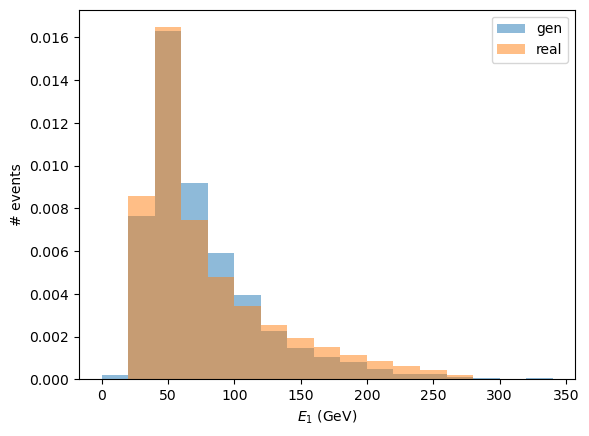

In [21]:
fig, axs = plt.subplots()

bins = np.arange(0, 350, step=20)
axs.hist(x_gen[:,0], alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(dy_trn_data[:,0], alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$E_{1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

Looks good!

We can do the same for $p_y$ of the first jet:

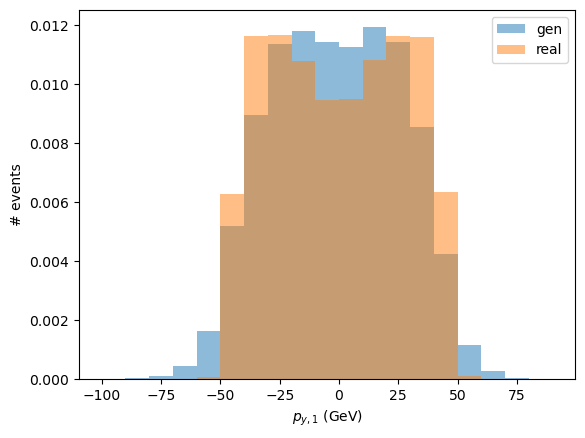

In [22]:
fig, axs = plt.subplots()

bins = np.arange(-100, +100, step=10)
axs.hist(x_gen[:,2], alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(dy_trn_data[:,2], alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$p_{y,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

The network struggles to get the double peak structure and the sharply decaying tails of the real data right.

In [23]:
x_gen_evnt_ims, x_gen_evnt_pts, x_gen_jet1_pts, x_gen_jet2_pts = get_obs(x_gen)

/tmp/ipykernel_8120/1194887628.py:6: RuntimeWarning: invalid value encountered in sqrt
  evnt_im = np.sqrt(np.sum((evnt_4m[:,0]**2, -evnt_4m[:,1]**2, -evnt_4m[:,2]**2, -evnt_4m[:,3]**2 ), axis=0))


The $p_T$ of the first jet:

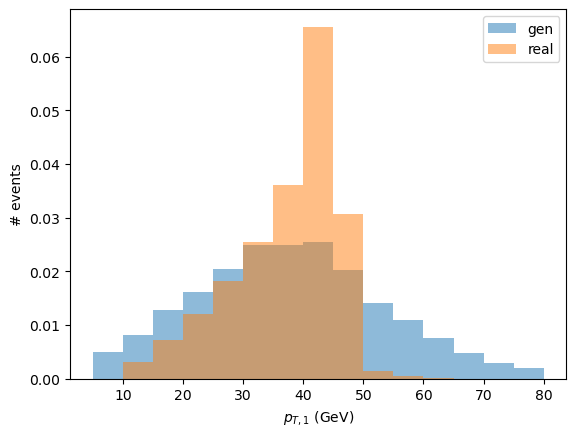

In [24]:
fig, axs = plt.subplots()

bins = np.arange(5, 85, step=5)
axs.hist(x_gen_jet1_pts, alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(trn_jet1_pts, alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$p_{T,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

Again, you can see that the network struggles to reproduce the distribution, espectially the steep decay at $m_Z / 2$

Now the invariant mass of the whole event:

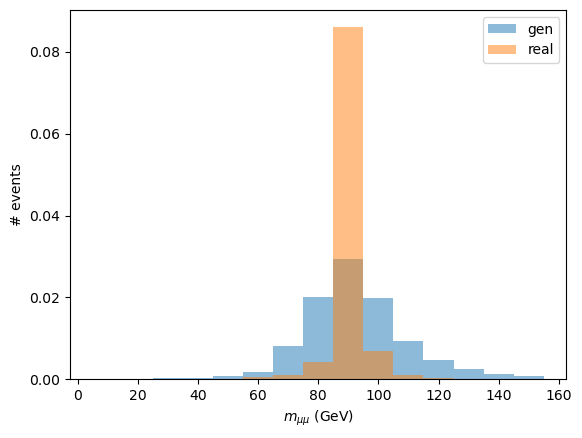

In [25]:
fig, axs = plt.subplots()

bins = np.arange(5, 165, step=10)
axs.hist(np.nan_to_num(x_gen_evnt_ims), alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(np.nan_to_num(trn_evnt_ims), alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

While the mass peak is centered at the correct position, it is much wider than in the real data.

## Removing redundant degrees of freedom

In the collider the incoming particles have no momentum in the $x$ or $y$ directions, therefore momentum conservation means that the final state should also not have any momentum in these directions.  This means that we have redundant degrees of freedom that can be removed from the data.

We can check this:

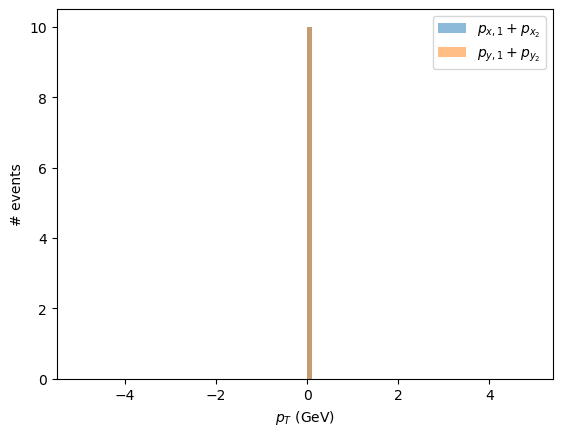

In [26]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
axs.hist(dy_trn_data[:,1]+dy_trn_data[:,5], alpha=0.5, density=True, bins=bins, label='$p_{x,1}+p_{x_2}$')
axs.hist(dy_trn_data[:,2]+dy_trn_data[:,6], alpha=0.5, density=True, bins=bins, label='$p_{y,1}+p_{y_2}$')

axs.set_xlabel("$p_T$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

Muons have a mass of about $106$ MeV.  This is much smaller than the typical energy scales involved in the Drell-Yan process we are studying, so we can assume to a good approximation that the mass of the final state particles are zero.  These final state particles are on-shell, i.e. $p^2=m^2=0$, so we can also use this as a constraint.  We can check that this approximately holds:

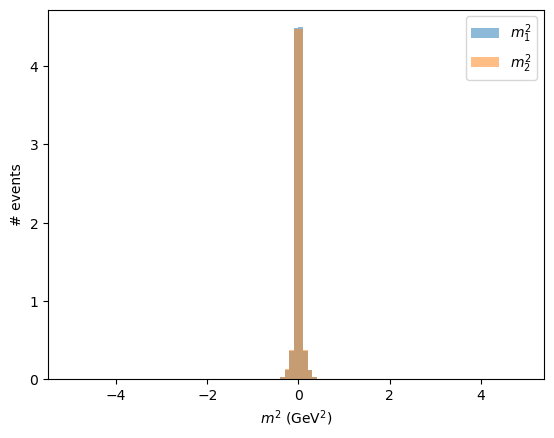

In [27]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
axs.hist(dy_trn_data[:,0]**2-dy_trn_data[:,1]**2-dy_trn_data[:,2]**2-dy_trn_data[:,3]**2, 
         alpha=0.5, density=True, bins=bins, label='$m_1^2$')
axs.hist(dy_trn_data[:,4]**2-dy_trn_data[:,5]**2-dy_trn_data[:,6]**2-dy_trn_data[:,7]**2, 
         alpha=0.5, density=True, bins=bins, label='$m_2^2$')

axs.set_xlabel("$m^2$ (GeV$^2$)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

We can remove 4 degrees of freedom from the data. For the remaining 4 degrees of freedom, we can choose a more suitable representation that takes into account the symmetries of our data:
- $p_T = \sqrt{p_{x,1}^2+p_{y,1}^2}$
- $\eta_1 = \text{arctanh}\left(\frac{p_{z,1}}{\sqrt{p_{x,1}^2+p_{y,1}^2+p_{z,1}^2}}\right)$
- $\eta_2 = \text{arctanh}\left(\frac{p_{z,2}}{\sqrt{p_{x,2}^2+p_{y,2}^2+p_{z,2}^2}}\right)$
- $\phi = \text{arctan2}(p_{y,1}, p_{x,1})$

We know that $\phi$ is uniformly distributed, so we don't have to train the network on it and just sample it from a uniform distribution. So we are left with 3 degrees of freedom.

Let's re-do the data.

In [28]:
def remove_dof(data_full):
    pt = np.sqrt(data_full[:,1]**2 + data_full[:,2]**2)
    eta1 = np.arctanh(data_full[:,3] / np.sqrt(data_full[:,1]**2 + data_full[:,2]**2 + data_full[:,3]**2))
    eta2 = np.arctanh(data_full[:,7] / np.sqrt(data_full[:,5]**2 + data_full[:,6]**2 + data_full[:,7]**2))
    return np.stack((pt, eta1, eta2), axis=1)
    
def add_dof(data_red):
    pt = data_red[...,0]
    eta1 = data_red[...,1]
    eta2 = data_red[...,2]
    phi1 = np.random.uniform(0, 2*np.pi, data_red.shape[:-1])
    px1 = pt * np.cos(phi1)
    py1 = pt * np.sin(phi1)
    pz1 = pt * np.sinh(eta1)
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = pt * np.sinh(eta2)
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

In [29]:
dy_trn_data_nr = remove_dof(dy_trn_data)
dy_val_data_nr = remove_dof(dy_val_data)
dy_tst_data_nr = remove_dof(dy_tst_data)

In [30]:
dy_trn_data_nr.shape, dy_val_data_nr.shape, dy_tst_data_nr.shape

((1384081, 3), (296588, 3), (296588, 3))

In [31]:
trn_mean_nr = np.mean(dy_trn_data_nr, axis=0)
trn_std_nr = np.std(dy_trn_data_nr, axis=0)
dy_trn_data_nr_p = torch.Tensor((dy_trn_data_nr - trn_mean_nr) / trn_std_nr)
dy_val_data_nr_p = torch.Tensor((dy_val_data_nr - trn_mean_nr) / trn_std_nr)
dy_tst_data_nr_p = torch.Tensor((dy_tst_data_nr - trn_mean_nr) / trn_std_nr)

In [32]:
trn_dataset_nr = TensorDataset(dy_trn_data_nr_p)
val_dataset_nr = TensorDataset(dy_val_data_nr_p)
tst_dataset_nr = TensorDataset(dy_tst_data_nr_p)
trn_dataloader_nr = DataLoader(trn_dataset_nr, batch_size=2500, shuffle=True)
val_dataloader_nr = DataLoader(val_dataset_nr, batch_size=2500, shuffle=True)
tst_dataloader_nr = DataLoader(tst_dataset_nr, batch_size=2500, shuffle=True)

Let's double check it:

In [33]:
trn_events_nr = add_dof(dy_trn_data_nr)
val_events_nr = add_dof(dy_val_data_nr)
tst_events_nr = add_dof(dy_tst_data_nr)

trn_evnt_nr_ims, trn_evnt_nr_pts, trn_jet1_nr_pts, trn_jet2_nr_pts = get_obs(trn_events_nr)
val_evnt_nr_ims, val_evnt_nr_pts, val_jet1_nr_pts, val_jet2_nr_pts = get_obs(val_events_nr)
tst_evnt_nr_ims, tst_evnt_nr_pts, tst_jet1_nr_pts, tst_jet2_nr_pts = get_obs(tst_events_nr)

Plot $p_{y,1}$ (they are not exactly the same because we throw away $\phi$ and then sample it again):

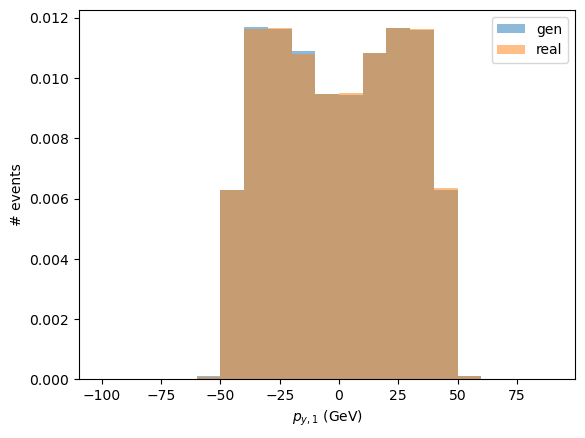

In [34]:
fig, axs = plt.subplots()

bins = np.arange(-100, +100, step=10)
axs.hist(trn_events_nr[:,2], alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(dy_trn_data[:,2], alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$p_{y,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

Let's plot the invariant mass of the events:

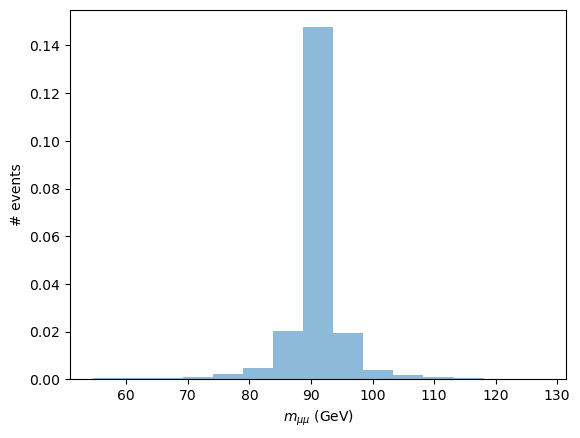

In [35]:
fig, axs = plt.subplots()

axs.hist(trn_evnt_nr_ims, alpha=0.5, density=True, bins=15)
axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("# events")
plt.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV.

Now let's look at $p_T$ distributions:

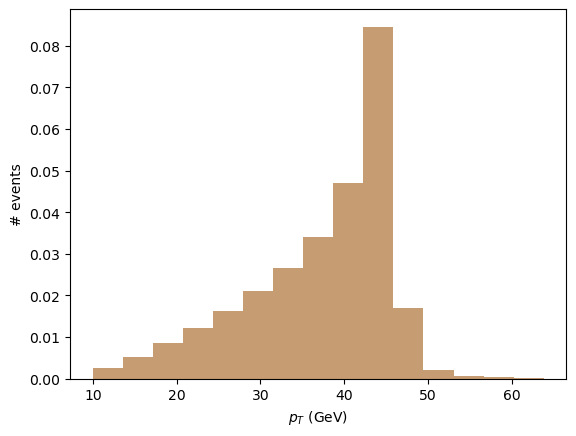

In [36]:
fig, axs = plt.subplots()

axs.hist(trn_jet1_nr_pts, alpha=0.5, density=True, bins=15)
axs.hist(trn_jet2_nr_pts, alpha=0.5, density=True, bins=15)

axs.set_xlabel("$p_{T}$ (GeV)")
axs.set_ylabel("# events")
plt.show()

So we can recover the original distributions.  Let's move on.

## Optimising the INN on the reduced data

In [37]:
# a useful function to present things clearer
def separator():
    print("-----------------------------------------------")

epochs = 10

# re-initialise the model and the optimizer
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 32), 
        nn.ReLU(),
        nn.Linear(32, 32), 
        nn.ReLU(),
        nn.Linear(32, dims_out)
    )
ndim_nr = 3
inn_nr = Ff.SequenceINN(ndim_nr)
for k in range(8):
    inn_nr.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)
learning_rate = 0.001
optimizer_nr = torch.optim.Adam(inn_nr.parameters(), lr=learning_rate)
separator()
print("model architecture ")
separator()
print(inn_nr)

# track train and val losses
trn_losses_nr = []
val_losses_nr = []

for t in range(epochs):
    separator()
    print(f"Epoch {t+1}")
    separator()
    train_epoch(trn_dataloader_nr, inn_nr, optimizer_nr)
    separator()
    trn_loss = trn_pass(trn_dataloader_nr, inn_nr)
    trn_losses_nr.append(trn_loss)
    separator()
    val_loss = val_pass(val_dataloader_nr, inn_nr)
    val_losses_nr.append(val_loss)
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
SequenceINN(
  (module_list): ModuleList(
    (0-7): 8 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=2, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.187902  [    0/1384081]
current batch loss: 0.080587  [250000/1384081]
current batch loss: 0.020658  [500000/1384081]
current batch loss: -0.003282  [750000/1384081]
current batch loss: -0.033349  [1000000/1384081]
current batch loss: -0.041562  [1250000/1384081]
-----------------------------------------------
avg trn loss per batch: -0.046876
-----------

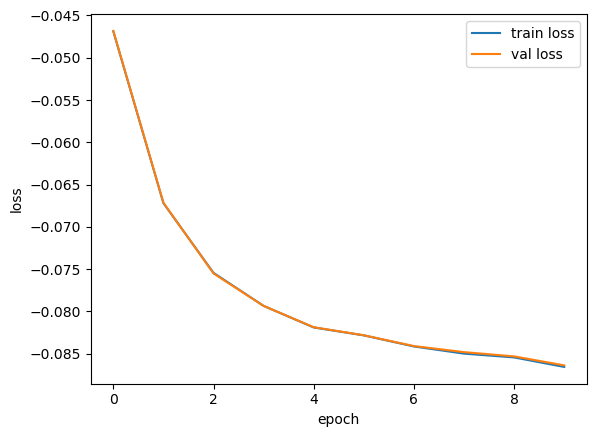

In [38]:
fig, axs = plt.subplots()

axs.plot(trn_losses_nr, label="train loss")
axs.plot(val_losses_nr, label="val loss")

axs.set_xlabel("epoch")
axs.set_ylabel("loss")
axs.legend()
plt.show()

## Study the new results

We now generate data and recover the original observables.

In [39]:
z_gen_nr = torch.randn((10000, ndim_nr))
x_gen_nr, _ = inn_nr(z_gen_nr, rev=True)
x_gen_nr = x_gen_nr.detach().numpy() * trn_std_nr + trn_mean_nr
x_gen_nr = add_dof(x_gen_nr)

Plot the energy distribution of the first jet, for both real and generated data:

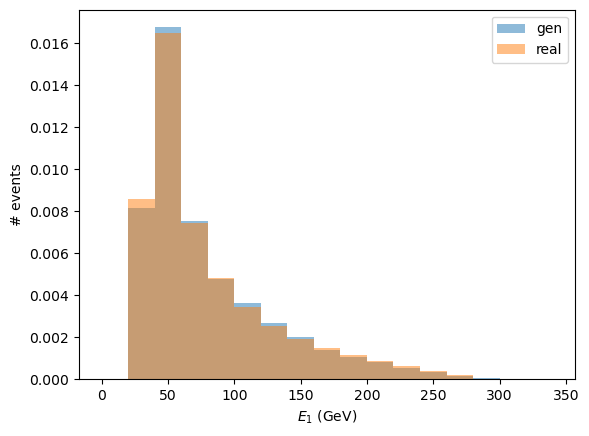

In [40]:
fig, axs = plt.subplots()

bins = np.arange(0, 350, step=20)
axs.hist(x_gen_nr[:,0], alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(dy_trn_data[:,0], alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$E_{1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

This time, the generated data matches the truth data better than before!

We can do the same for $p_y$ of the first jet:

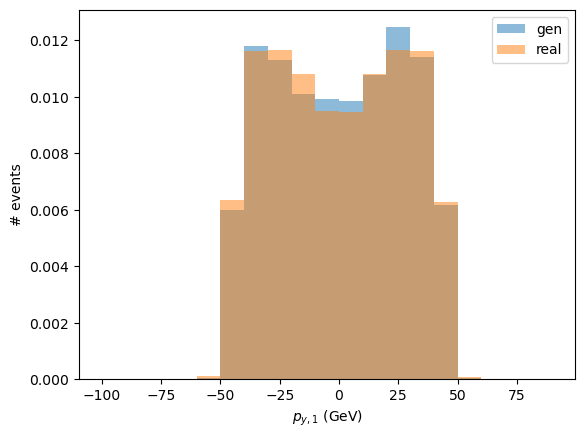

In [41]:
fig, axs = plt.subplots()

bins = np.arange(-100, +100, step=10)
axs.hist(x_gen_nr[:,6], alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(dy_trn_data[:,6], alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$p_{y,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

This looks much better than before! Let's look at some other observables.

First we need to calucate them from the generated data:

In [42]:
x_gen_evnt_nr_ims, x_gen_evnt_nr_pts, x_gen_jet1_nr_pts, x_gen_jet2_nr_pts = get_obs(x_gen_nr)

The $p_T$ of the first jet:

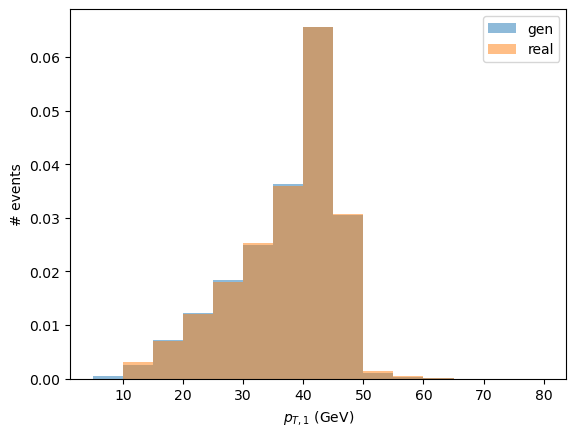

In [43]:
fig, axs = plt.subplots()

bins = np.arange(5, 85, step=5)
axs.hist(x_gen_jet1_nr_pts, alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(trn_jet1_nr_pts, alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$p_{T,1}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

Looks great!

Now the invariant mass of the whole event:

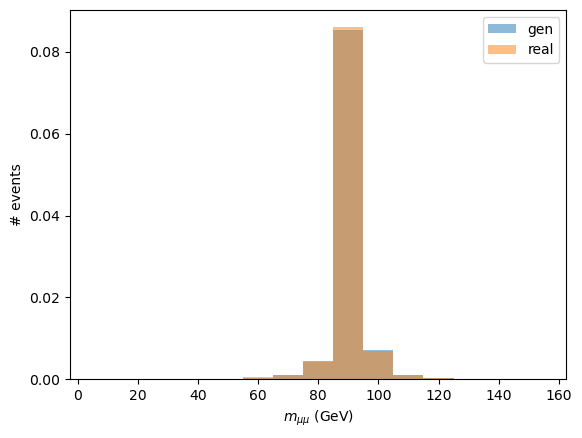

In [44]:
fig, axs = plt.subplots()

bins = np.arange(5, 165, step=10)
axs.hist(np.nan_to_num(x_gen_evnt_nr_ims), alpha=0.5, density=True, bins=bins, label='gen')
axs.hist(np.nan_to_num(trn_evnt_ims), alpha=0.5, density=True, bins=bins, label='real')

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("# events")
axs.legend()
plt.show()

The match between the two mass distributions looks really good now!